# Sentiment Analysis in Nepali Language

This google colab is about sentiment analysis in Nepali language by fine-tuning BERT-derivative model. The dataset used in this notebook is mainly from [here](https://github.com/oya163/nepali-sentiment-analysis/blob/master/data/nepcls/csv/ss_ac_at_txt_unbal.csv)

## Installation

In [62]:
%%capture
!python3 -m pip install -U huggingface_hub
!python3 -m pip install -U transformers
!python3 -m pip install -U datasets evaluate
!python3 -m pip install -U accelerate
!python3 -m pip install -U seqeval
!python3 -m pip install -U wandb
!pip install ipywidgets

  Obtaining dependency information for huggingface_hub from https://files.pythonhosted.org/packages/05/09/1945ca6ba3ad8ad6e2872ba682ce8d68c5e63c8e55458ed8ab4885709f1d/huggingface_hub-0.19.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 6.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.14.1 requires huggingface_hub<0.18,>=0.16.4, but you have huggingface-hub 0.19.4 which is incompatible.
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/12/dd/f17b11a93a9ca27728e12512d167eb1281c151c4c6881d3ab59eb58f4127/transformers-4.35.2-py3-none-any.whl.metadata
     

In [ ]:
# Wrap the text in ipython notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

import warnings
warnings.filterwarnings("ignore")

## Prepare NepSA dataset

This is related to creating a dataset based off of the raw dataset from [Nepali Sentiment Analysis](https://raw.githubusercontent.com/oya163/nepali-sentiment-analysis/master/data/nepcls/csv/ss_ac_at_txt_unbal.csv) project

In [4]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import numpy as np
pd.set_option('display.max_colwidth', None)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# filepath = '/content/drive/MyDrive/nepsa_data/nepsa'

In [12]:
!wget https://raw.githubusercontent.com/merishnaSuwal/nep-off-langdetect/main/NepSA/dataset/balanced/ss_ac_at_txt_bal.csv
!wget https://raw.githubusercontent.com/merishnaSuwal/nep-off-langdetect/main/NepSA/dataset/imbalanced/ss_ac_at_txt_unbal.csv

--2023-12-03 23:24:55--  https://raw.githubusercontent.com/merishnaSuwal/nep-off-langdetect/main/NepSA/dataset/balanced/ss_ac_at_txt_bal.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467471 (457K) [text/plain]
Saving to: ‘ss_ac_at_txt_bal.csv.2’

ss_ac_at_txt_bal.cs 100%[===================>] 456.51K  --.-KB/s    in 0.02s   

2023-12-03 23:24:55 (27.5 MB/s) - ‘ss_ac_at_txt_bal.csv.2’ saved [467471/467471]

--2023-12-03 23:24:56--  https://raw.githubusercontent.com/merishnaSuwal/nep-off-langdetect/main/NepSA/dataset/imbalanced/ss_ac_at_txt_unbal.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:

In [5]:
filepath = "/kaggle/working/ss_ac_at_txt_bal.csv"
bal_ds = pd.read_csv(filepath, names=["Severity", "Category", "Aspect Word", "text"])
bal_ds = bal_ds[bal_ds['Category'] != "FEEDBACK"]

In [6]:
bal_ds.head()

,Severity,Category,Aspect Word,text
0,1,GENERAL,शोषक,यो मुजि बानियाँ ले कस्तो खाते कुरा गर्दैछ कुलमान नभए को आज नेपाल उज्यालो हुन्थ्यो अझ कुलमान को कमजोरी देखाउछ यिनी 2 त शोषक हुन ।
1,1,GENERAL,उल्लु बनाए,सबै भन्दा ठुलो सरकार ले नै सबै लाई उल्लु बनाए को छ बाँकी पैसा त खान्छन नै यो अहिले को सरकार तुरुन्त धाल्नु पर्छ ।
2,1,GENERAL,न पहिला ठिक थियो न अहिले ठिक छ,यो पुलिस न पहिला ठिक थियो न अहिले ठिक छ यस्तो लाई बोलाउनु हुदैन ?
3,1,GENERAL,चोर,यिनी चोर हरु ले जनता लाई अन्धकार मा रखेर आफ्नो धुनु सुधारने कुकुर हरु हुन कुलमन सार ले गरे को ठिक काम हो ।
4,1,GENERAL,हरास,सहि कुरा के पि को अस्तित्व हरास हुदैछ !


In [7]:
bal_ds['Category'].unique()

array(['GENERAL', 'PROFANITY', 'VIOLENCE'], dtype=object)

In [8]:
def create_label(row):
    if row['Category'] == "GENERAL" and row['Severity'] == 0:
        return 0
    elif row['Category'] == "GENERAL" and row['Severity'] == 1:
        return 1
    elif row['Category'] == "PROFANITY":
        return 2
    elif row['Category'] == "VIOLENCE":
        return 3
    else:
        return None

bal_ds['label'] = bal_ds.apply(create_label, axis=1).astype(int)

bal_ds = bal_ds.drop(['Severity', 'Category', 'Aspect Word'], axis=1)
bal_ds.head()

,text,label
0,यो मुजि बानियाँ ले कस्तो खाते कुरा गर्दैछ कुलमान नभए को आज नेपाल उज्यालो हुन्थ्यो अझ कुलमान को कमजोरी देखाउछ यिनी 2 त शोषक हुन ।,1
1,सबै भन्दा ठुलो सरकार ले नै सबै लाई उल्लु बनाए को छ बाँकी पैसा त खान्छन नै यो अहिले को सरकार तुरुन्त धाल्नु पर्छ ।,1
2,यो पुलिस न पहिला ठिक थियो न अहिले ठिक छ यस्तो लाई बोलाउनु हुदैन ?,1
3,यिनी चोर हरु ले जनता लाई अन्धकार मा रखेर आफ्नो धुनु सुधारने कुकुर हरु हुन कुलमन सार ले गरे को ठिक काम हो ।,1
4,सहि कुरा के पि को अस्तित्व हरास हुदैछ !,1


In [9]:
label_map = {
    0: 'GENERAL POSITIVE',
    1: 'GENERAL NEGATIVE',
    2: 'PROFANITY',
    3: 'VIOLENCE'
}

## Dataset statistics

<Axes: xlabel='custom_label'>

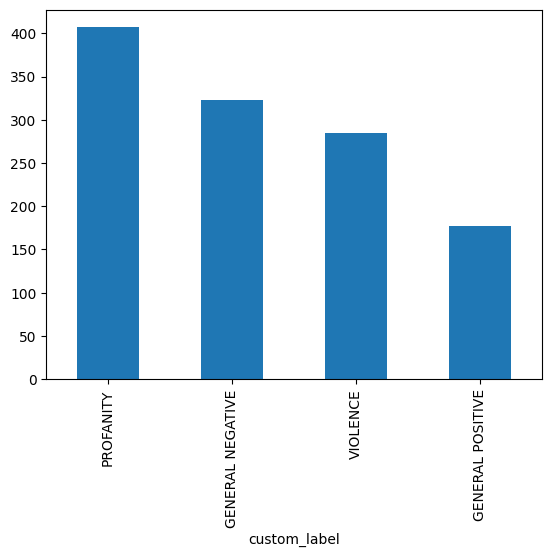

In [10]:
import matplotlib.pyplot as plt

# Create a new column with custom labels based on the mapping
bal_ds['custom_label'] = bal_ds['label'].map(label_map)

# Plot the bar chart with custom labels
bal_ds['custom_label'].value_counts().plot(kind='bar')

In [15]:
filepath = "/kaggle/working/ss_ac_at_txt_unbal.csv"
imbal_ds = pd.read_csv(filepath, names=["Severity", "Category", "Aspect Word", "text"])

def create_imbal_label(row):
    if row['Category'] == "GENERAL" and row['Severity'] == 0:
        return "GENERAL_POSITIVE"
    elif row['Category'] == "GENERAL" and row['Severity'] == 1:
        return "GENERAL_NEGATIVE"
    else:
        return row['Category'] 
    
imbal_ds['label'] = imbal_ds.apply(create_imbal_label, axis=1)
imbal_ds = imbal_ds.drop(['Severity', 'Category', 'Aspect Word'], axis=1)
imbal_ds.head()

,text,label
0,गुठी विधेक ल्याएर ठमेल मा राज गुठि को जग्गा मा बने को छाया सेन्टर जस्ता लाई जोगाउन को लागि ल्याउदैछ विधेक ।,GENERAL_POSITIVE
1,दले ले देश सकेछन सबै बेचे र खान सुरू गरेछन अब दले लाई लखेटनु पछ ।,GENERAL_NEGATIVE
2,नेपाल को ससकृती ध्वस्त पार्ने योजना हो यो !,GENERAL_NEGATIVE
3,मठ मन्दिर गुम्बा का जग्गा हरु मा भुमाफिया को नजर परे को हुना ले यो विधेक आए को हो !,GENERAL_NEGATIVE
4,नेपाल का कल कर्खाना र नदि नाला बेची सके अब मठ मन्दीर लाई पनि बेची खाने नियत देखिन्छ ।,GENERAL_NEGATIVE


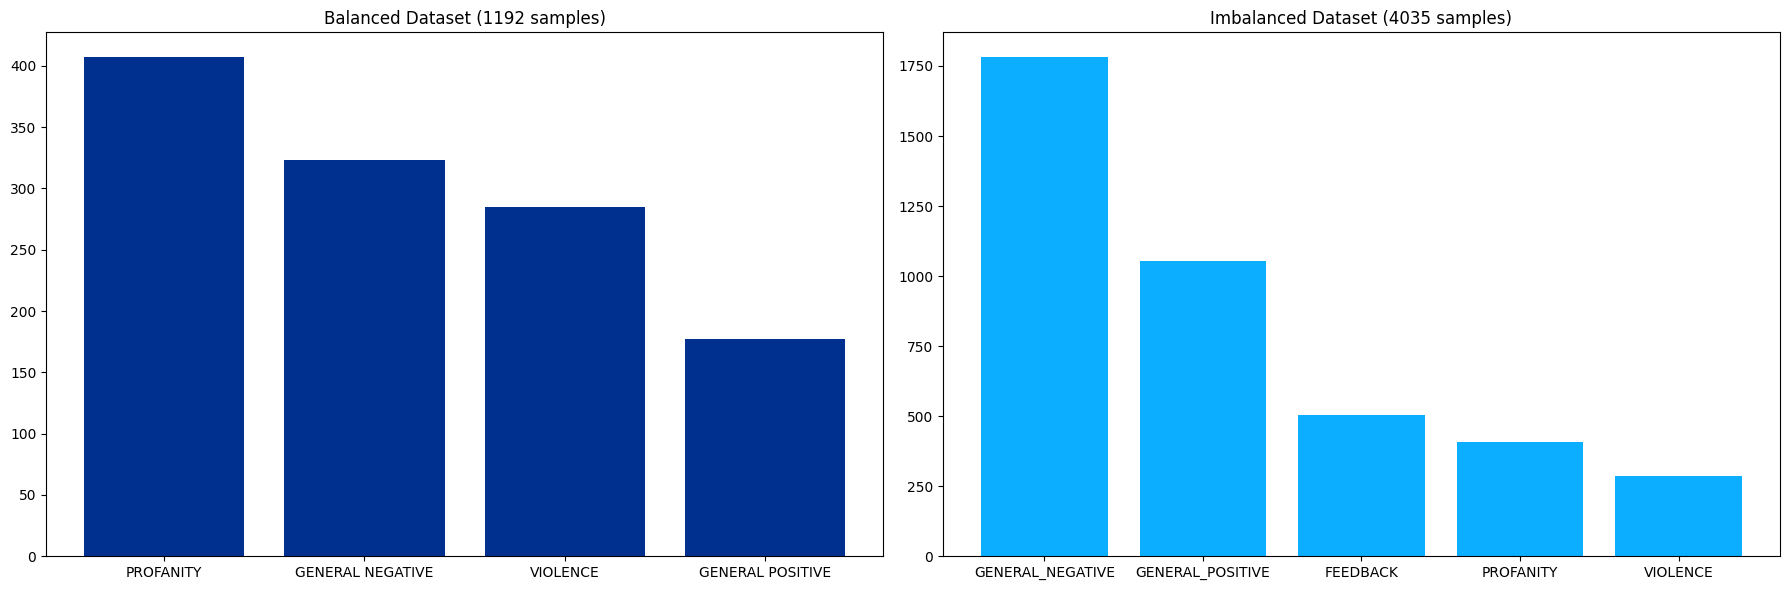

In [16]:
# Set up the subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6)) #, sharex=True)

# Plot the first subplot (for bal_ds)
axs[0].bar(bal_ds['custom_label'].value_counts().index, bal_ds['custom_label'].value_counts(), color='#00308F')
axs[0].set_title(f'Balanced Dataset ({bal_ds.shape[0]} samples)')

# Plot the second subplot (for imbal_ds)
axs[1].bar(imbal_ds['label'].value_counts().index, imbal_ds['label'].value_counts(), color='#0CAFFF')
axs[1].set_title(f'Imbalanced Dataset ({imbal_ds.shape[0]} samples)')

# Customize the layout
plt.tight_layout()

# Save the figure
plt.savefig('bal_vs_imbal.png', dpi=800)

# Display the plot
plt.show()

# Data Preprocessing

In [17]:
from sklearn.model_selection import train_test_split

df = bal_ds

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=163)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=163)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
def create_csv(X, y, filename):
    df = pd.DataFrame()
    df['text'] = X
    df['label'] = y
    df.to_csv(f"{filename}.txt", sep='\t', header=False, index=False)

create_csv(X_train, y_train, 'train')
create_csv(X_val, y_val, 'valid')
create_csv(X_test, y_test, 'test')

## Load NepSA dataset

In [19]:
! wget https://raw.githubusercontent.com/merishnaSuwal/nep-off-langdetect/main/NepSA/dataset/load_sa.py

--2023-12-03 23:29:44--  https://raw.githubusercontent.com/merishnaSuwal/nep-off-langdetect/main/NepSA/dataset/load_sa.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3784 (3.7K) [text/plain]
Saving to: ‘load_sa.py’

load_sa.py          100%[===================>]   3.70K  --.-KB/s    in 0s      

2023-12-03 23:29:45 (39.6 MB/s) - ‘load_sa.py’ saved [3784/3784]



In [20]:
import os
from datasets import load_dataset

filepath="/kaggle/working"
data_files = {
    "train": os.path.join(filepath, "train.txt"),
    "validation": os.path.join(filepath, "valid.txt"),
    "test": os.path.join(filepath, "test.txt"),
}

raw_datasets = load_dataset(os.path.join(filepath, "load_sa.py"), data_files=data_files)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/default-64b45d28d5e71cae/0.0.0/afde611d4a69f2ccee19ba20be745d5e4b7c6c93285903c7eca3d6161fe3507d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Check the basic information on the loaded dataset

In [21]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 714
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 239
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 239
    })
})

Check the data statistics

In [22]:
from collections import Counter

for k, v in raw_datasets.items():
    print(k, Counter(raw_datasets[k]['label']))

train Counter({2: 236, 1: 199, 3: 172, 0: 107})
validation Counter({2: 86, 1: 63, 3: 59, 0: 31})
test Counter({2: 85, 1: 61, 3: 54, 0: 39})


In [23]:
train_data = raw_datasets['train']
test_data = raw_datasets['test']
valid_data = raw_datasets['validation']

Check sample of tokens from train dataset

In [24]:
print(train_data[10]["text"])

यो खाते रन्डि को छोरा कस्तो मानव अधिकार बादी हो ?


Check the NER tags (its IDS) of the corresponding sample

In [25]:
print(raw_datasets["train"][10]["label"])

2


In [26]:
ner_feature = raw_datasets["train"].features["label"]
ner_feature.num_classes

4

## Tokenization

In [43]:
from transformers import AutoTokenizer

# model_checkpoint = "xlm-roberta-large"
# model_checkpoint = "bert-base-multilingual-uncased"
model_checkpoint = "Sakonii/deberta-base-nepali"
# model_checkpoint = "NepBERTa/NepBERTa"
# model_checkpoint = "Rajan/NepaliBERT"
# model_checkpoint = "Sakonii/distilbert-base-nepali"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Data Preprocessing

In [44]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=False)

tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_val = valid_data.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# Fine Tuning

## Data Collation

In [45]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Load pre-trained model

In [46]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=4,
    from_tf=True if model_checkpoint=="NepBERTa/NepBERTa" else False
)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at Sakonii/deberta-base-nepali and are newly initialized: ['pooler.dense.weight', 'classifier.weight', 'classifier.bias', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Setup Evaluation

In [47]:
import numpy as np
from sklearn.metrics import classification_report
from datasets import load_metric

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)

    accuracy = report['accuracy']
    recall = report['weighted avg']['recall']
    precision = report['weighted avg']['precision']
    f1 = report['weighted avg']['f1-score']
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }



In [48]:
model.config.num_labels

4

## Training

In [49]:
# from google.colab import userdata
# from huggingface_hub import login, notebook_login

# login(token=userdata.get('hugging_face'))

In [50]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy

model_name = "nepsa"

args = TrainingArguments(
    model_name,
    evaluation_strategy=IntervalStrategy.STEPS,
    eval_steps = 100,
    save_total_limit = 2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    num_train_epochs=10,
    weight_decay=0.01,
    push_to_hub=False,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01,)]
)

In [41]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb")
wandb.login(key=wandb_secret)

In [51]:
trainer.train()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
100,No log,1.341996,0.380753,0.380753,0.285551,0.311752
200,No log,1.286265,0.489540,0.489540,0.510161,0.470498
300,No log,1.372952,0.569038,0.569038,0.574425,0.564353
400,No log,1.665547,0.564854,0.564854,0.566860,0.565335


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=450, training_loss=0.6931456163194445, metrics={'train_runtime': 76.4049, 'train_samples_per_second': 93.45, 'train_steps_per_second': 5.89, 'total_flos': 274312069059792.0, 'train_loss': 0.6931456163194445, 'epoch': 10.0})

In [52]:
trainer.evaluate()

{'eval_loss': 1.6863007545471191,
 'eval_accuracy': 0.5732217573221757,
 'eval_recall': 0.5732217573221757,
 'eval_precision': 0.579591573210813,
 'eval_f1': 0.5744740094089286,
 'eval_runtime': 0.7585,
 'eval_samples_per_second': 315.098,
 'eval_steps_per_second': 19.776,
 'epoch': 10.0}

## Save the model

In [53]:
saved_model_path='nepsa'
trainer.save_model(saved_model_path)

## Evaluation

In [54]:
predictions = trainer.predict(tokenized_test)

In [55]:
import pandas as pd
final_predictions = np.argmax(predictions.predictions, axis=1)

label_map = {
    0: 'GENERAL POSITIVE',
    1: 'GENERAL NEGATIVE',
    2: 'PROFANITY',
    3: 'VIOLENCE'
}

prediction_data = []
for text, gt, pt in zip(tokenized_test['text'], tokenized_test['label'], final_predictions):
    prediction_data.append([text, gt, pt])
    
prediction_df = pd.DataFrame(prediction_data, columns=['text', 'ground_truth', 'predictions'])

In [56]:
# prediction_df[prediction_df['predictions']==0]

In [57]:
from sklearn.metrics import classification_report
report = classification_report(y_true=prediction_df['ground_truth'], y_pred=prediction_df['predictions'])
print(report)

              precision    recall  f1-score   support

           0       0.82      0.72      0.77        39
           1       0.50      0.59      0.54        61
           2       0.69      0.59      0.64        85
           3       0.56      0.63      0.59        54

    accuracy                           0.62       239
   macro avg       0.64      0.63      0.63       239
weighted avg       0.63      0.62      0.62       239



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [58]:
from tabulate import tabulate

metrics = ['precision', 'recall', 'f1', 'accuracy']
prediction_results = []

for key, val in predictions.metrics.items():
    if any(item in key for item in metrics):
        prediction_results.append([key, str(round(val,4)*100)+'%'])

print(tabulate(prediction_results, headers=['Metric', 'Score']))

Metric          Score
--------------  -------------------
test_accuracy   61.919999999999995%
test_recall     61.919999999999995%
test_precision  63.49%
test_f1         62.35000000000001%


## Inference

In [59]:
from transformers import pipeline

text_classifier = pipeline("text-classification", model=saved_model_path)

In [60]:
inference_sentences = ["वा जैनु जि तपाइलाइ धन्यबाद छ गगन्या चोर लाई मुख भरी जबाब दिएको मा",
                       "ओली दलाल मुर्दाबाद",
                       "यो गोविन्दे लाई देश निकाला गर्नु पर्छ",
                       "यो मुला गोबिन्द ठिक छैन",
                       "यो पुण्य गौतम जड्या हो जस्तो कस कस लाई लाग्छ ।",
                      "तपाईं कुवा मा दुबेर मरे हुन्छ ।",
                      "अनुहार हेर्दा ठमेल को भालू हो ।"]

results = text_classifier(inference_sentences)


In [61]:
label_map = {
    0: 'GENERAL POSITIVE',
    1: 'GENERAL NEGATIVE',
    2: 'PROFANITY',
    3: 'VIOLENCE'
}

prediction_results = []
for sent, result in zip(inference_sentences, results):
    pred = result['label'].split('_')[1]
    prediction_results.append([sent, pred, label_map[int(pred)]])

print(tabulate(prediction_results, headers=['Sentences', 'Labels', 'Remarks'], tablefmt='orgtbl'))


| Sentences                                                    |   Labels | Remarks          |
|--------------------------------------------------------------+----------+------------------|
| वा जैनु जि तपाइलाइ धन्यबाद छ गगन्या चोर लाई मुख भरी जबाब दिएको मा |        1 | GENERAL NEGATIVE |
| ओली दलाल मुर्दाबाद                                             |        1 | GENERAL NEGATIVE |
| यो गोविन्दे लाई देश निकाला गर्नु पर्छ                              |        1 | GENERAL NEGATIVE |
| यो मुला गोबिन्द ठिक छैन                                         |        1 | GENERAL NEGATIVE |
| यो पुण्य गौतम जड्या हो जस्तो कस कस लाई लाग्छ ।                    |        1 | GENERAL NEGATIVE |
| तपाईं कुवा मा दुबेर मरे हुन्छ ।                                     |        3 | VIOLENCE         |
| अनुहार हेर्दा ठमेल को भालू हो ।                                   |        2 | PROFANITY        |


## Conclusion

### Sakonii/distilbert-base-nepali


                  precision    recall  f1-score   support

               0       0.75      0.62      0.68        39
               1       0.53      0.62      0.57        61
               2       0.68      0.61      0.65        85
               3       0.56      0.61      0.58        54

        accuracy                           0.62       239
    
       macro avg       0.63      0.62      0.62       239
    weighted avg       0.63      0.62      0.62       239



### xlm-roberta-large

                    precision    recall  f1-score   support

               0       0.00      0.00      0.00        39
               1       0.00      0.00      0.00        61
               2       0.36      1.00      0.52        85
               3       0.00      0.00      0.00        54

        accuracy                           0.36       239
       macro avg       0.09      0.25      0.13       239
    weighted avg       0.13      0.36      0.19       239

### Rajan/NepaliBERT

                  precision    recall  f1-score   support

               0       0.70      0.67      0.68        39
               1       0.48      0.64      0.55        61
               2       0.74      0.59      0.65        85
               3       0.64      0.63      0.64        54

        accuracy                           0.62       239
       macro avg       0.64      0.63      0.63       239
    weighted avg       0.64      0.62      0.63       239
    
### Sakonii/deberta-base-nepali

                    
                    precision    recall  f1-score   support

               0       0.82      0.72      0.77        39
               1       0.50      0.59      0.54        61
               2       0.69      0.59      0.64        85
               3       0.56      0.63      0.59        54

        accuracy                           0.62       239
       macro avg       0.64      0.63      0.63       239
    weighted avg       0.63      0.62      0.62       239
